In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from datetime import datetime
# Get the current time
current_time = datetime.now()
# Print the current time
print("Current time:", current_time)
!pip install dataretrieval
from dataretrieval import nwis
import random
from google.colab import drive
drive.mount('/content/drive')
!pip install hydroeval
import hydroeval as he
# Set seeds for all major libraries
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Current time: 2025-06-17 19:55:35.469097
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- 1. Generate Sample Data (Replace with your actual DataFrame) ---
# Assuming your DataFrame 'df' is already loaded.
# For demonstration, let's create a sample DataFrame:
#np.random.seed(42) # for reproducibility
#dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
#x1 = np.sin(np.linspace(0, 50, 200)) + np.random.rand(200) * 0.5
#x2 = np.cos(np.linspace(0, 40, 200)) * 0.8 + np.random.rand(200) * 0.3
#y = 0.7 * x1 + 0.3 * x2 + np.sin(np.linspace(0, 60, 200)) * 0.5 + np.random.rand(200) * 0.2
#df = pd.DataFrame({'date': dates, 'x1': x1, 'x2': x2, 'y': y})

#print("Sample DataFrame Head:")
#print(df.head())
#print("\nDataFrame Info:")
#df.info()

In [3]:
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
"13311450"
               #'13190500' #'12305000' #'13340000' #'13317660'
#

 #'13192200'
 #'13211205'
 #'13311250'
         #     '13341050'
# '13150430'
          #    '13092747'
#  '13304050'
  #'13307000' #"13296000"
  #
   #'13176400' #
# '13310800'
#  '12305000'


  #


  #'13340600' #
              #'13310850' #
   #'13311000'
              # '13342500'
            #  '13213000'# not enough data
#

   #
    #  #
   #
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]



parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )





dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year


dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]


shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
#prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
#print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date'
#, "rad_d"
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  '00010_Mean', '00060_Mean'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 3 , 8+1 ))


print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

# Print the cleaned DataFrame
print("df_cleaned:",df_cleaned)

# Print the cleaned DataFrame
print(" df_cleaned.describe():",df_cleaned.describe())

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

site_info_df:   agency_cd   site_no                   station_nm site_tp_cd    lat_va  \
0      USGS  13311450  SUGAR CREEK NR STIBNITE, ID         ST  445610.9   

     long_va  dec_lat_va  dec_long_va coord_meth_cd  coord_acy_cd  ...  \
0  1152014.0   44.936361  -115.337222             G             5  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
0            NaN        NaN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                     geometry  
0           NaN          NaN         NaN  POINT (-115.33722 44.93636)  

[1 rows x 43 columns]
station_nm: SUGAR CREEK NR STIBNITE, ID
train_month: [3, 4, 5, 6, 7, 8]
df_cleaned:           tmean   site_no       Date  00010_Mean  00060_Mean
225    2.788000  13311450 2012-04-29         3.9       79.70
226    2.260000  13311450 2012-04-30         3.4       70.00
227    1.621000  13311450 2012-05-01         3.6       62.10
228    1.074000  13311450 20

<ipython-input-3-3127052391>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [4]:
#features = ['x1', 'x2']
#target = 'y'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#scaler_features = MinMaxScaler(feature_range=(0, 1))
#scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
#df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
#df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

#print("\nDataFrame after Normalization Head:")
#print(df.head())

In [5]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#  the minimum of feature is made equal to zero and the maximum of feature equal to one.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
#print(df.head())
print(df.tail())
#print(df.shape)

(1690, 5)
(1690, 5)

DataFrame after Normalization Head:
         tmean   site_no       Date  00010_Mean  00060_Mean
4728  0.692518  13311450 2024-08-27    0.679389    0.027813
4729  0.576276  13311450 2024-08-28    0.641221    0.027171
4730  0.656352  13311450 2024-08-29    0.595420    0.026971
4731  0.730341  13311450 2024-08-30    0.641221    0.026168
4732  0.778150  13311450 2024-08-31    0.679389    0.025726


<ipython-input-6-46837385>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['Date'] = pd.to_datetime(df_12['Date'])


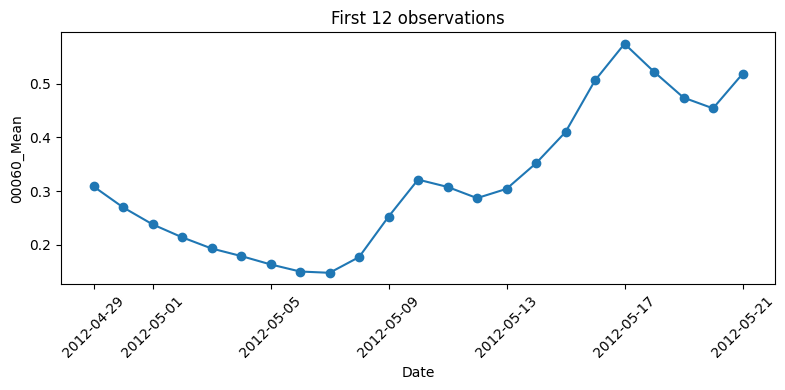

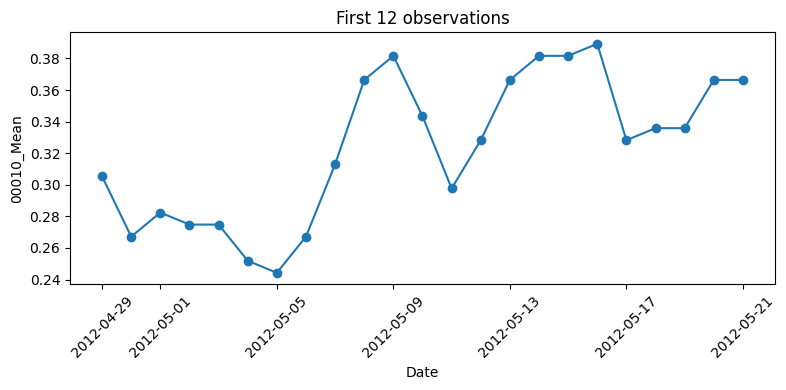

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your full DataFrame is called `df`
# 1) Keep only the first 12 rows
df_12 = df.head(23)        # or df.iloc[:12]

# 2) Make sure 'Date' is datetime (skip if it already is)
df_12['Date'] = pd.to_datetime(df_12['Date'])

# 3) Plot
plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00060_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00060_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00010_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00010_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back =  12 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    #print(data.head)
    print("data_np:",data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back +1), :num_features]) # (i + look_back +1) will include the feature of the day of the target
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column


    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print("X", X) # did I miss today's X?

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

data_np: [[0.43165197 0.30847648 0.30534351]
 [0.41665883 0.26954567 0.26717557]
 [0.39851372 0.23783914 0.28244275]
 ...
 [0.65635174 0.02697062 0.59541985]
 [0.73034061 0.02616792 0.64122137]
 [0.77814974 0.02572644 0.67938931]]
X [[[0.43165197 0.30847648]
  [0.41665883 0.26954567]
  [0.39851372 0.23783914]
  ...
  [0.58558726 0.25228769]
  [0.40419294 0.32131963]
  [0.43190754 0.30767378]]

 [[0.41665883 0.26954567]
  [0.39851372 0.23783914]
  [0.38298105 0.21375823]
  ...
  [0.40419294 0.32131963]
  [0.43190754 0.30767378]
  [0.51221173 0.28680366]]

 [[0.39851372 0.23783914]
  [0.38298105 0.21375823]
  [0.38488359 0.1928881 ]
  ...
  [0.43190754 0.30767378]
  [0.51221173 0.28680366]
  [0.60322125 0.30406165]]

 ...

 [[0.78651947 0.03355274]
  [0.8124508  0.03234869]
  [0.80206348 0.03154599]
  ...
  [0.69251844 0.02781345]
  [0.57627615 0.0271713 ]
  [0.65635174 0.02697062]]

 [[0.8124508  0.03234869]
  [0.80206348 0.03154599]
  [0.74070662 0.0299406 ]
  ...
  [0.57627615 0.02717

In [8]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")


print(f"Test samples: {len(X_test)}")
print(f" Y Train samples: {len(Y_train)}")


print(f"Y Test samples: {len(Y_test)}")

Train samples: 1342
Test samples: 336
 Y Train samples: 1342
Y Test samples: 336


In [9]:
print("X_train[0]:", X_train[0])
print("Y_train[0]:", Y_train[0])


print("df.head(6)",df.head(6))
#print("X:", X)
#print("Y:", Y)


#print("X_train:", X_train)
#print("Y_train:", Y_train)
print("Y_train.shape:", Y_train.shape)
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)

X_train[0]: [[0.43165197 0.30847648]
 [0.41665883 0.26954567]
 [0.39851372 0.23783914]
 [0.38298105 0.21375823]
 [0.38488359 0.1928881 ]
 [0.34339688 0.17884091]
 [0.26703976 0.16318831]
 [0.35174534 0.14994381]
 [0.47552395 0.14753572]
 [0.56519885 0.17683416]
 [0.58558726 0.25228769]
 [0.40419294 0.32131963]
 [0.43190754 0.30767378]]
Y_train[0]: 0.29770992366412213
df.head(6)         tmean   site_no       Date  00010_Mean  00060_Mean
225  0.431652  13311450 2012-04-29    0.305344    0.308476
226  0.416659  13311450 2012-04-30    0.267176    0.269546
227  0.398514  13311450 2012-05-01    0.282443    0.237839
228  0.382981  13311450 2012-05-02    0.274809    0.213758
229  0.384884  13311450 2012-05-03    0.274809    0.192888
230  0.343397  13311450 2012-05-04    0.251908    0.178841
Y_train.shape: (1342,)
X_train.shape: (1342, 13, 2)
Y_train.shape: (1342,)


<ipython-input-10-2831626437>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([array1, array2],


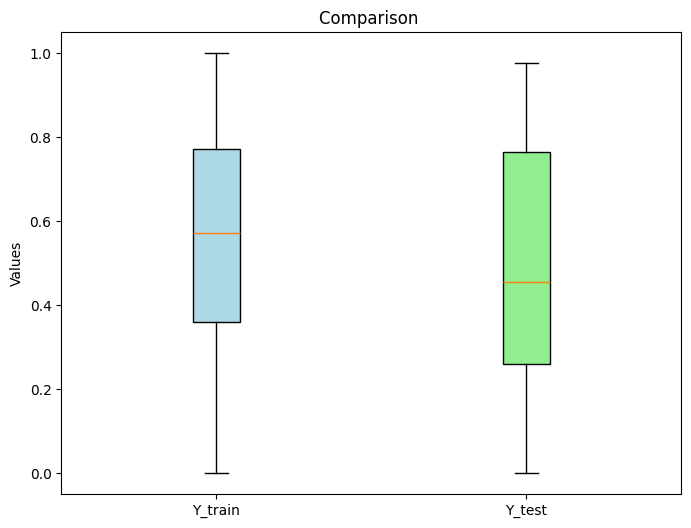

Number of zeros Y_train: 2


In [10]:


import matplotlib.pyplot as plt
import numpy as np  # Only needed if you're creating example data

# Example data (replace with your actual arrays)
array1 = Y_train
array2 =  Y_test

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create the boxplot
boxplot = plt.boxplot([array1, array2],
                     patch_artist=True,
                     labels=['Y_train', 'Y_test'])

# Customize colors (optional)
colors = ['lightblue', 'lightgreen']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Add title and labels
plt.title('Comparison ')
plt.ylabel('Values')

# Show the plot
plt.show()

num_zeros = Y_train.size - np.count_nonzero(Y_train)

print(f"Number of zeros Y_train: {num_zeros}")

In [11]:
# --- 5. Build LSTM Model ---
h1=  256
h2 =  100
learning_rate = 0.0001
optimizer= Adam(learning_rate= learning_rate ) #'adam'
#Adadelta(learning_rate=learning_rate)
d1 = 0.1
d2 = 0.05

model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units= h1, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout( d1 )) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units= h2, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout( d2 ))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.__class__.__name__}, Activation: {getattr(layer, 'activation', 'N/A')}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,117 (1.56 MB)

 Trainable params: 408,117 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Layer 0: LSTM, Activation: <function tanh at 0x7d768efe2480>
Layer 1: Dropout, Activation: N/A
Layer 2: LSTM, Activation: <function tanh at 0x7d768efe2480>
Layer 3: Dropout, Activation: N/A
Layer 4: Dense, Activation: <function linear at 0x7d768efe2ac0>


Epoch 1/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0741 - val_loss: 0.0209
Epoch 2/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0153 - val_loss: 0.0184
Epoch 3/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136 - val_loss: 0.0167
Epoch 4/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0122 - val_loss: 0.0148
Epoch 5/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - val_loss: 0.0129
Epoch 6/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - val_loss: 0.0121
Epoch 7/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089 - val_loss: 0.0104
Epoch 8/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0084 - val_loss: 0.0102
Epoch 9/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - val_loss: 0.0092
Epoch 10/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0089
Epoch 11/105
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068 - val_loss: 0.0084
Epoch 12/105
135/135 ━━━━━━━━━━━━━━━━━━━

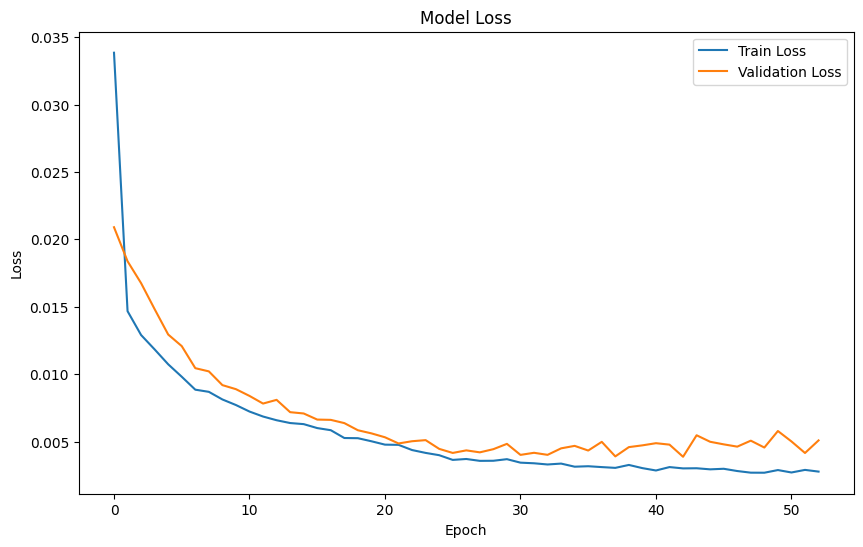

In [12]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch =  8
history = model.fit(X_train, Y_train,
                    epochs=105, # You can increase epochs, EarlyStopping will handle it
                    batch_size= batch ,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

#print(history)
# Print the epoch the model stopped at
print(f"Training stopped at epoch: {len(history.history['loss'])}")

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,224,353 (4.67 MB)

 Trainable params: 408,117 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 816,236 (3.11 MB)

In [14]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0026
Test Loss (MSE): 0.0029


In [15]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

r2 = r2_score( Y_test_original ,  Y_pred )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
kge_value, r_comp, alpha_comp, beta_comp = he.kge( Y_pred , Y_test_original)
#print( kge_value)

std_ratio = np.std( Y_pred ) / np.std( Y_test_original ) # standard deviation ratio
correlation = np.corrcoef( Y_pred.flatten() ,  Y_test_original.flatten() )[0, 1]
print("correlation", correlation)

print(np.std(Y_pred))
print(np.std(Y_test_original))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Shape of Y_pred_scaled: (336, 1)
Shape of Y_test: (336,)
Shape of X_test: (336, 13, 2)
Test RMSE: 0.7024
Test bias: -0.0724
correlation 0.9825411353618179
3.4470835
3.664001234354524


In [16]:



# Example arrays
x = np.array([1, 2, 3, 4, 5])
print(x.shape)
y = np.array([2, 4, 6, 8, 10])

# Compute the correlation coefficient matrix
correlation_matrix = np.corrcoef(x, y)

# Extract the correlation coefficient (Pearson's r)
correlation_example = correlation_matrix[0, 1]

print("Correlation coefficient:", correlation_example)


print("Y_test_original",Y_test_original.shape)
print("Y_test_original",type(Y_test_original) )
print(np.isnan(Y_test_original).sum())
print(np.isinf(Y_test_original).sum())
print("Y_pred",Y_pred.shape)
print("Y_pred",type(Y_pred))
print(np.isnan(Y_pred).sum())
print(np.isinf(Y_pred).sum())

(5,)
Correlation coefficient: 0.9999999999999999
Y_test_original (336, 1)
Y_test_original <class 'numpy.ndarray'>
0
0
Y_pred (336, 1)
Y_pred <class 'numpy.ndarray'>
0
0


In [17]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


#dt_ys = df_cleaned[train_size:len(Y)]#['Date']

print("df_cleaned.tail:",df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']

dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

print( "dt_ys.tail()", dt_ys.tail() )

print( dt_ys['Date'].dt.month.describe())

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

print("summer_df.tail()",summer_df.tail())

summer_df.to_csv( ( model_site[0] + "summer_df.csv") )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

df_cleaned.tail: <bound method NDFrame.tail of          tmean   site_no       Date  00010_Mean  00060_Mean
225   0.431652  13311450 2012-04-29    0.305344    0.308476
226   0.416659  13311450 2012-04-30    0.267176    0.269546
227   0.398514  13311450 2012-05-01    0.282443    0.237839
228   0.382981  13311450 2012-05-02    0.274809    0.213758
229   0.384884  13311450 2012-05-03    0.274809    0.192888
...        ...       ...        ...         ...         ...
4728  0.692518  13311450 2024-08-27    0.679389    0.027813
4729  0.576276  13311450 2024-08-28    0.641221    0.027171
4730  0.656352  13311450 2024-08-29    0.595420    0.026971
4731  0.730341  13311450 2024-08-30    0.641221    0.026168
4732  0.778150  13311450 2024-08-31    0.679389    0.025726

[1690 rows x 5 columns]>
1342
1678
dt_ys.tail()          tmean   site_no       Date  00010_Mean  00060_Mean    Y_pred  \
4728  0.692518  13311450 2024-08-27    0.679389    0.027813  8.083525   
4729  0.576276  13311450 2024-08-28   

<ipython-input-17-1200362995>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
<ipython-input-17-1200362995>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
<ipython-input-17-1200362995>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

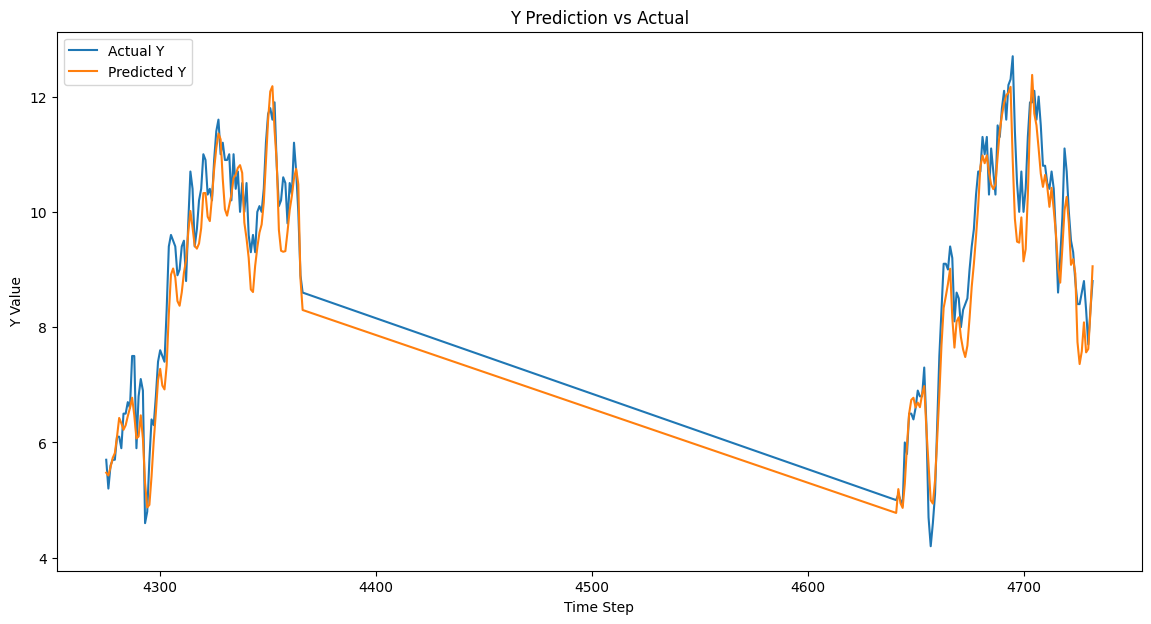

In [18]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

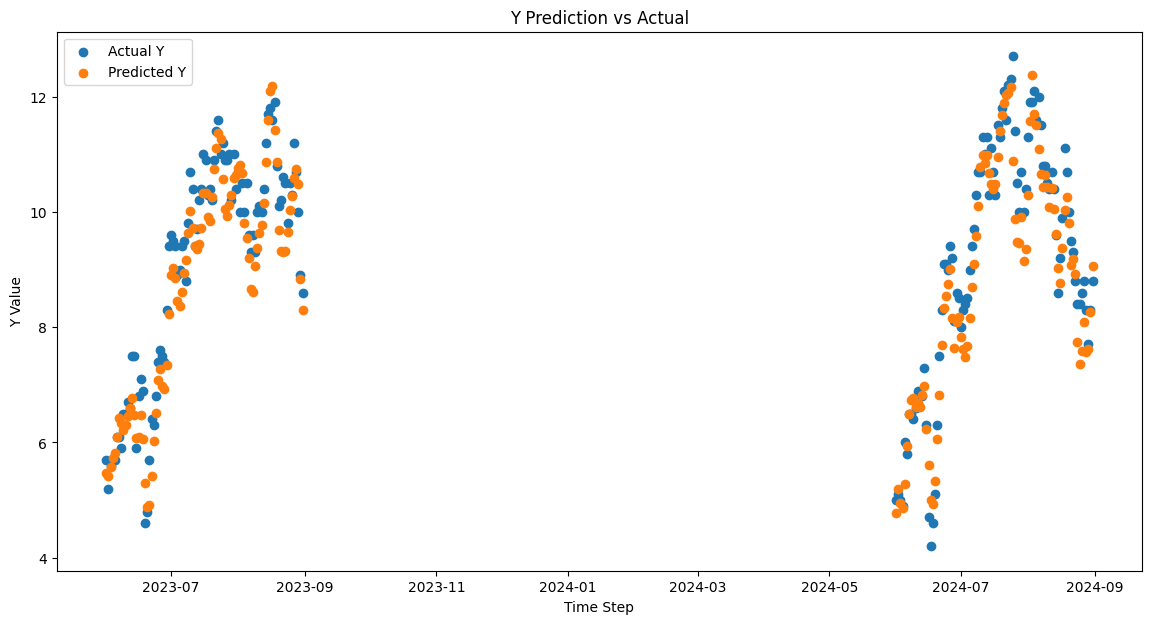

In [19]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

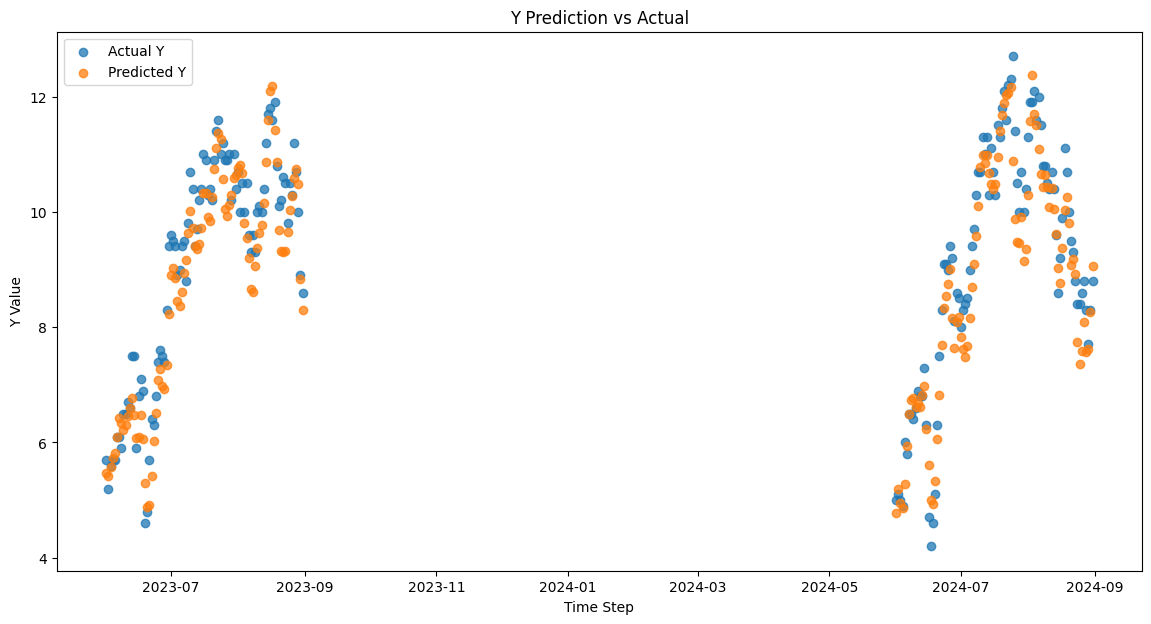

In [20]:
small= summer_df[0:256]
alpha=0.75
plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y',alpha=alpha)



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

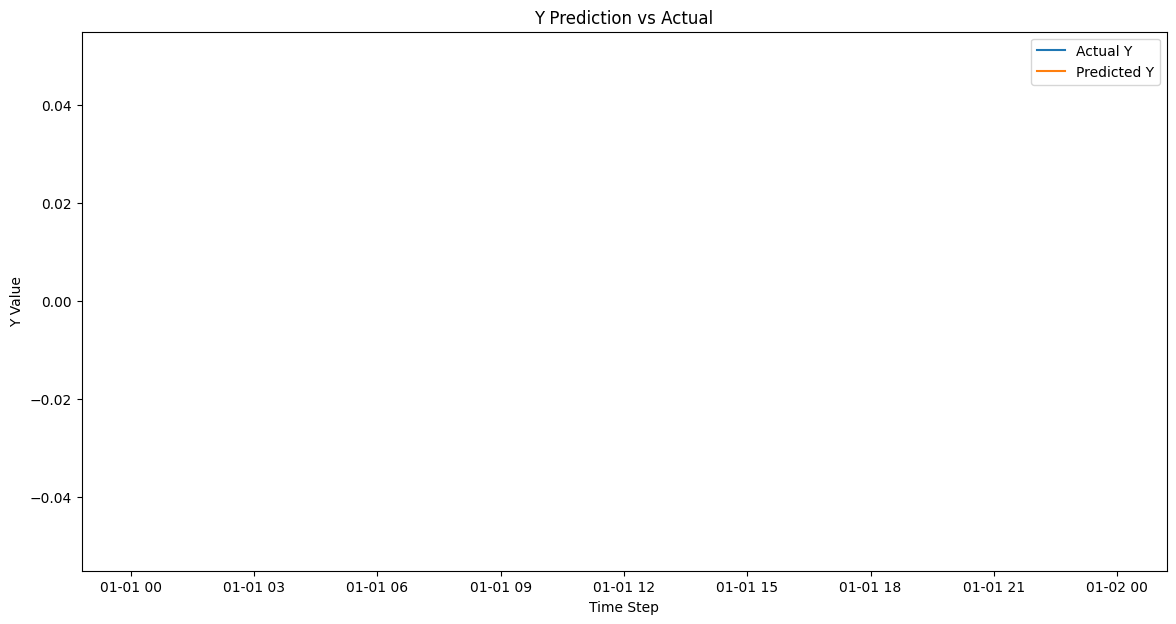

In [21]:
small= summer_df[187:256]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

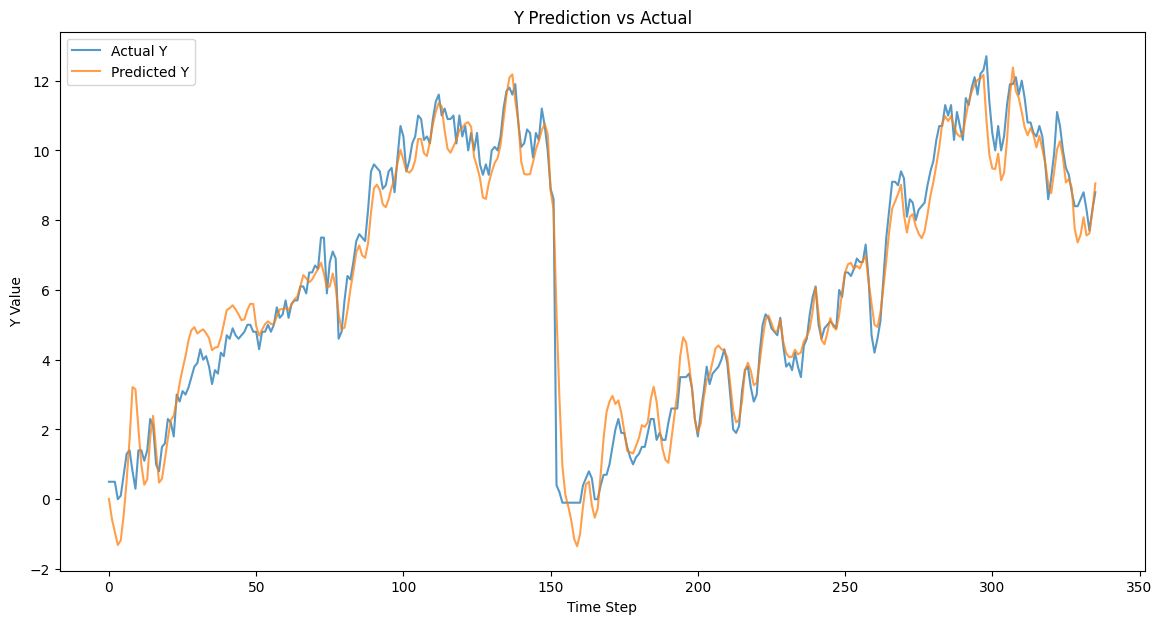

In [22]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y' ,alpha=alpha )
plt.plot(Y_pred, label='Predicted Y' ,alpha=alpha)
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()


In [23]:
result_df = pd.DataFrame({
    "current_time":[current_time],
                          "model_site": [model_site[0]],
                          "train_month" : [train_month]
                          , "h1":[h1]
                          ,"h2":[h2]
                          ,"d1":[d1]
                          ,"d2":[d2]
                          ,"batch":[batch]
                          ,"look_back":[look_back]


                          ,"optimizer":[optimizer]
    ,'learning_rate':[learning_rate]
    ,"r2" :[r2]
    , "rmse":[rmse]
                           , "bias":[bias]

                       ,   "std_ratio" :[std_ratio]
                        ,  "correlation" :[correlation]


    ,"KGE" : [kge_value]
,"KGE_r_comp" : [r_comp]
,"KGE_alpha_comp" : [alpha_comp]
,"KGE_beta_comp" : [beta_comp]
    })

print(result_df)


result_df.to_csv( model_site[0]+'_result_df.csv' , index=False)

result_df.to_csv('/content/drive/My Drive/LSTM_results/' + model_site[0]+'_result_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)


                current_time model_site         train_month   h1   h2   d1  \
0 2025-06-17 19:55:35.469097   13311450  [3, 4, 5, 6, 7, 8]  256  100  0.1   

     d2  batch  look_back                                          optimizer  \
0  0.05      8         12  <keras.src.optimizers.adam.Adam object at 0x7d...   

   learning_rate        r2      rmse     bias  std_ratio  correlation  \
0         0.0001  0.963254  0.566136 -0.07244   0.940798     0.982541   

                    KGE            KGE_r_comp        KGE_alpha_comp  \
0  [0.9372001550661387]  [0.9825411353618185]  [0.9407975742161093]   

       KGE_beta_comp  
0  [0.9884206498211]  


In [24]:
#model.save( (model_site[0]+'_lstm_model.h5') )

         tmean   site_no       Date  00010_Mean  00060_Mean    Y_pred  \
4275  0.618799  13311450 2023-06-01    0.442748    0.406004  5.475536   
4276  0.584838  13311450 2023-06-02    0.404580    0.384733  5.426801   
4277  0.639327  13311450 2023-06-03    0.435115    0.373896  5.569407   
4278  0.645636  13311450 2023-06-04    0.442748    0.369080  5.731286   
4279  0.636246  13311450 2023-06-05    0.442748    0.364665  5.814620   

      Y_test_original      bias  
4275              5.7 -0.224464  
4276              5.2  0.226801  
4277              5.6 -0.030593  
4278              5.7  0.031286  
4279              5.7  0.114620  


<ipython-input-25-2963098943>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']


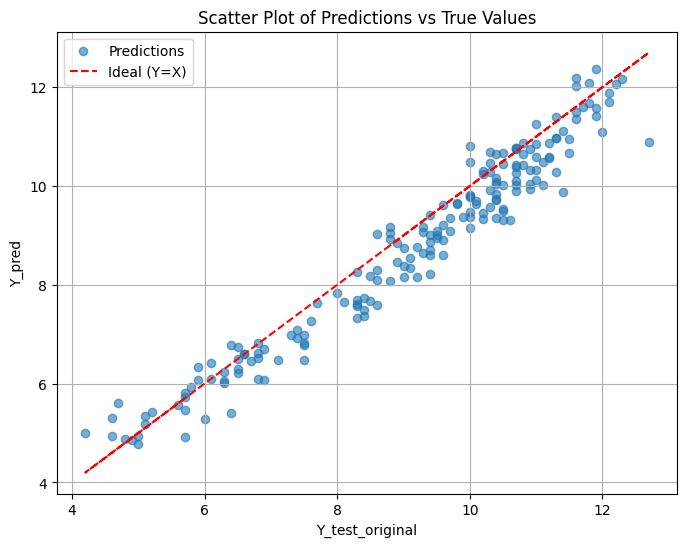

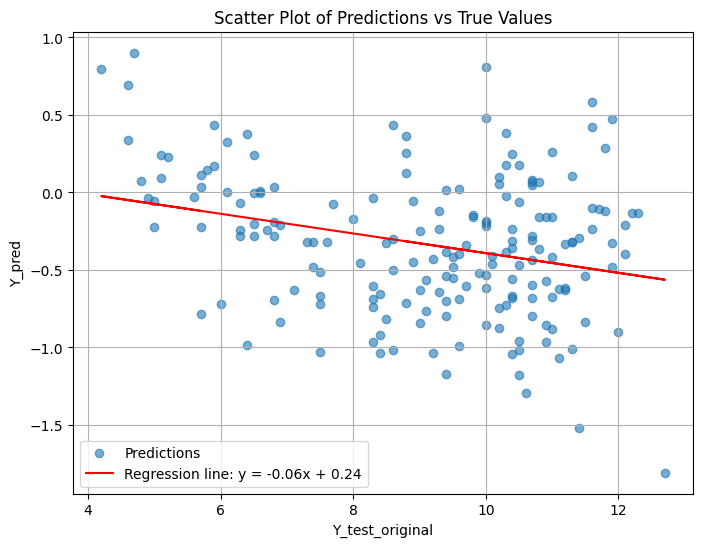

In [25]:
summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']
print( summer_df.head() )

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['Y_pred'], alpha=0.6, label='Predictions')
plt.plot( summer_df['Y_test_original'],  summer_df['Y_test_original'], color='red', linestyle='--', label='Ideal (Y=X)')
plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['bias'], alpha=0.6, label='Predictions')

# Calculate regression line
coefficients = np.polyfit(  summer_df['Y_test_original'],  summer_df['bias'] , 1)  # 1 for linear regression
polynomial = np.poly1d(coefficients)
y_pred = polynomial(  summer_df['Y_test_original']  )
# Plot regression line
plt.plot(  summer_df['Y_test_original'] , y_pred, color='red', label=f'Regression line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')


plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

         tmean   site_no       Date  00010_Mean  00060_Mean    Y_pred  \
4275  0.618799  13311450 2023-06-01    0.442748    0.406004  5.475536   
4276  0.584838  13311450 2023-06-02    0.404580    0.384733  5.426801   
4277  0.639327  13311450 2023-06-03    0.435115    0.373896  5.569407   
4278  0.645636  13311450 2023-06-04    0.442748    0.369080  5.731286   
4279  0.636246  13311450 2023-06-05    0.442748    0.364665  5.814620   
...        ...       ...        ...         ...         ...       ...   
4728  0.692518  13311450 2024-08-27    0.679389    0.027813  8.083525   
4729  0.576276  13311450 2024-08-28    0.641221    0.027171  7.562682   
4730  0.656352  13311450 2024-08-29    0.595420    0.026971  7.622002   
4731  0.730341  13311450 2024-08-30    0.641221    0.026168  8.262681   
4732  0.778150  13311450 2024-08-31    0.679389    0.025726  9.056092   

      Y_test_original      bias  
4275              5.7 -0.224464  
4276              5.2  0.226801  
4277              5.6

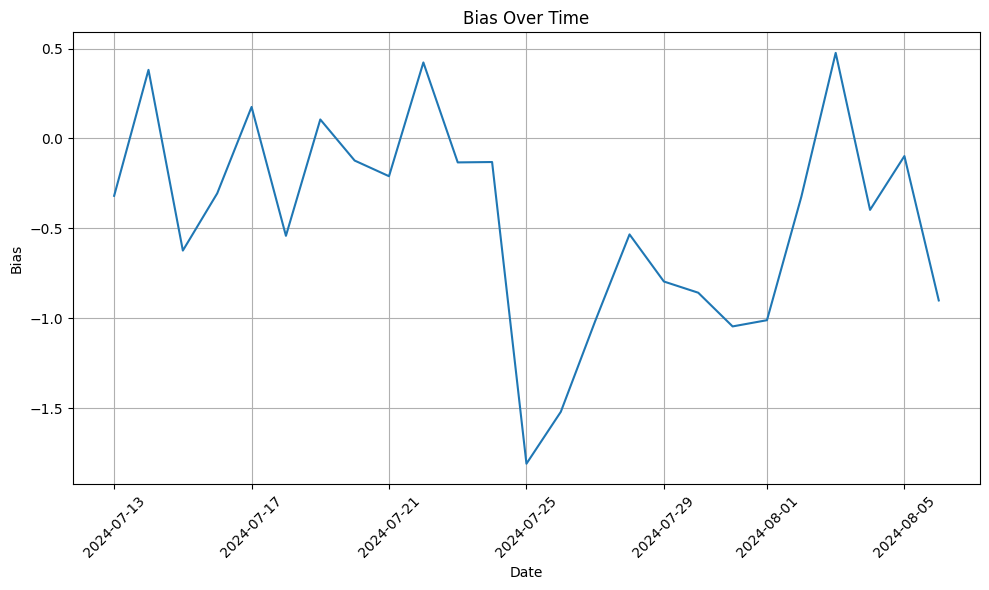

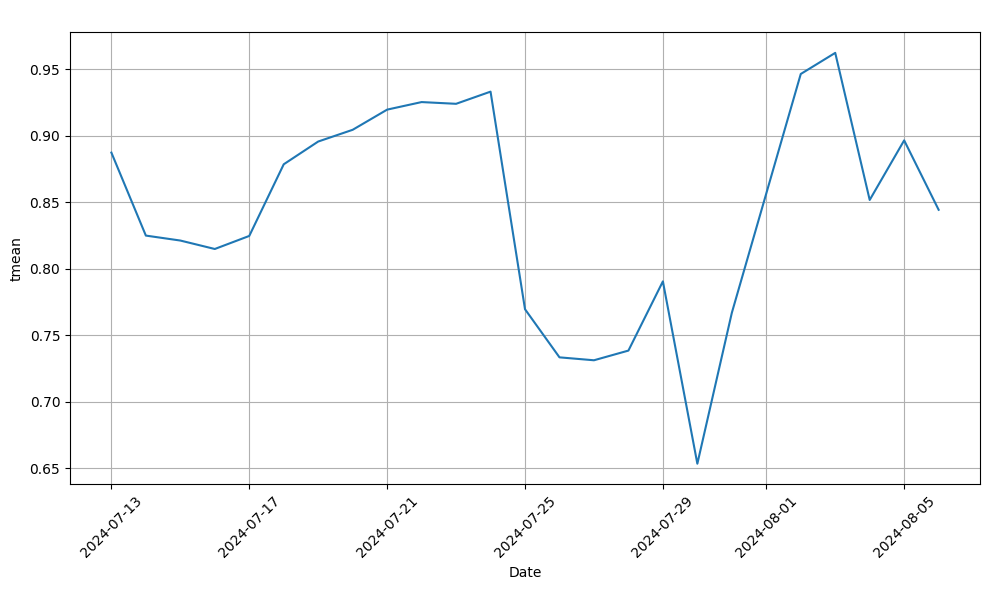

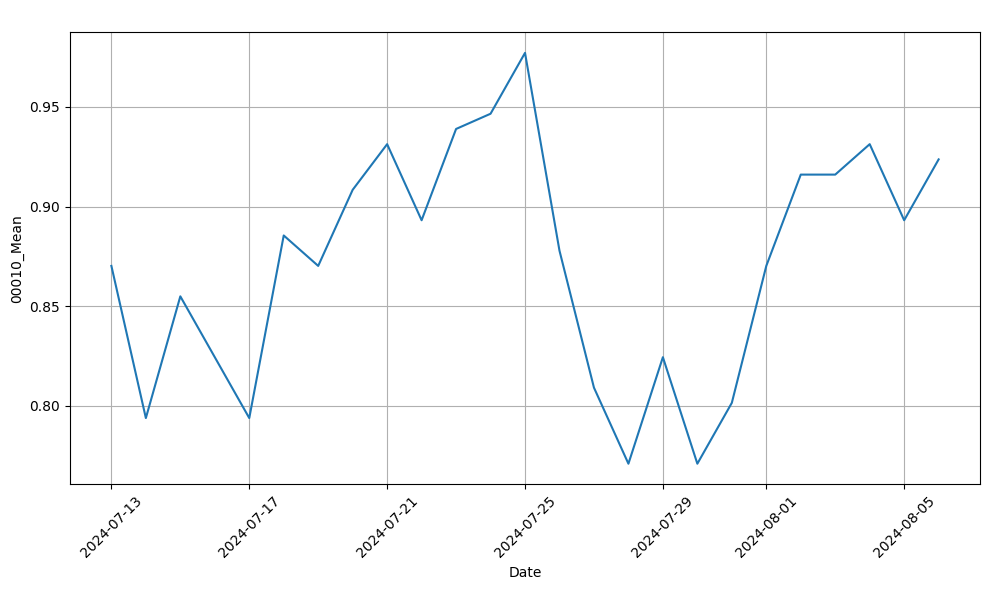

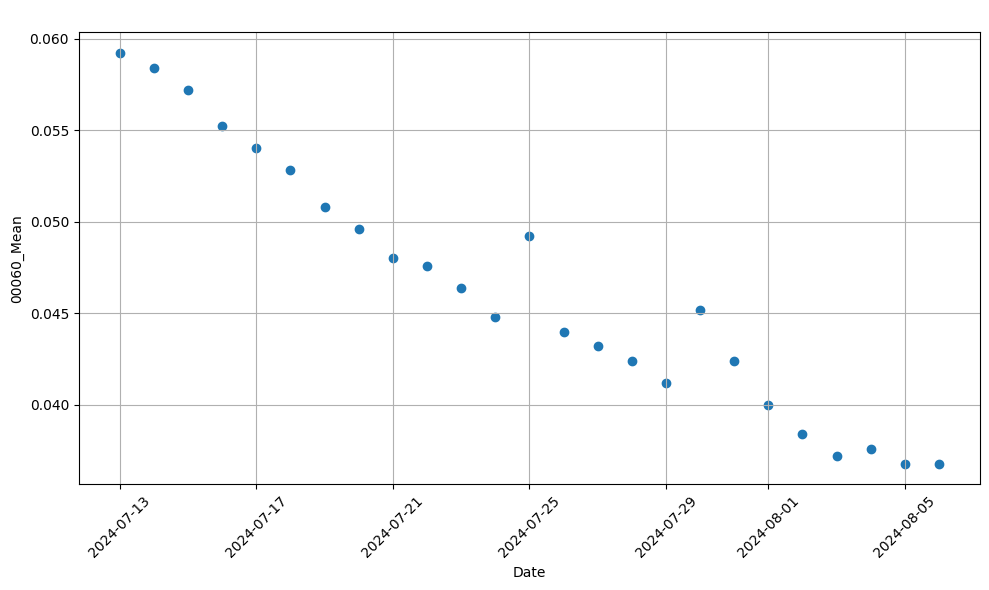

In [26]:
print(summer_df)

# --- prep ---
#summer_df['Date'] = summer_df.to_datetime( subset_rows['Date'])      # make sure Date is datetime
summer_df = summer_df.sort_values('Date').reset_index(drop=True)

# --- locate the peak bias ---
idx_peak   = summer_df['bias'].idxmin()             # row index of the max bias
date_peak  = summer_df.at[idx_peak, 'Date']         # corresponding date

# ------- OPTION 1: ±12 *days* around that date -------
start_day  = date_peak - pd.Timedelta(days=12)
end_day    = date_peak + pd.Timedelta(days=12)

subset_days = summer_df[(summer_df['Date'] >= start_day) & ( summer_df['Date'] <= end_day)].copy()

# ------- OPTION 2: ±12 *rows* around that row index -------
start_idx  = max(idx_peak - 12, 0)
end_idx    = min(idx_peak + 12, len(df) - 1)

subset_rows = summer_df.loc[start_idx : end_idx].copy()
subset_rows


# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows['bias'])

# Customizing the plot
plt.title('Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Bias')
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()





####

# Plotting
yvar = 'tmean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00010_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00060_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

https://www.sciencedirect.com/science/article/pii/S2214581824000648#sec0030